1. Pre-Processing

In [ ]:

import cv2# for image processing
import numpy as np#For converting the data into numpy arrays
import glob#used to read all the files given the folder / directory
import pickle#to store the data extracted from each of the files
from scipy.interpolate import griddata# algorithms for interpolation ,Interpolate unstructured D-D data.
data= {}
epsilon = 1e-8
N = 80
y = []
error = []

number_iter = 1000#number of images

psd1D_total = np.zeros([number_iter, N])# 1000 by 80 matrix of 0.
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0
#Calculate the azimuthally averaged radial profile.
def azimuthalAverage(image, center=None):
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    # Calculate the center indices from the image
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.hypot(x - center[0], y - center[1])
   #for sorted radii
    ind = np.argsort(r.flat) #
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]
    # For the integral part of the radii
    r_int = r_sorted.astype(int)
     # Find all pixels that fall within each radial bin.
        #Binning groups continuous data into categories defined by specific ranges
    deltar = r_int[1:] - r_int[:-1]
    rind = np.where(deltar)[0]
    nr = rind[1:] - rind[:-1]
    # Cumulative sum to get each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]
    radial_prof = tbin / nr
    return radial_prof
#fake data
rootdir = '/content/drive/MyDrive/A17_CSE1_19JG/PROJECT-1/IMPLEMENTATION_FILES/dataset_celebA1/'

for filename in glob.glob(rootdir+"*.jpg"):
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)#Compute the 2-dimensional discrete Fourier Transform.
    fshift = np.fft.fftshift(f)#Shift the zero-frequency component to the center of the spectrum
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)


    points = np.linspace(0,N,num=psd1D.size) #co ordinates of a point
    xi = np.linspace(0,N,num=N) #co ordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')#Interpolate unstructured D-D data.
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])

psd1D_total2 = np.zeros([number_iter, N])#Return a new array of given shape and type, filled with zeros.
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
#real data
rootdir2 = '/content/drive/MyDrive/A17_CSE1_19JG/PROJECT-1/IMPLEMENTATION_FILES/img_align_celeba1/'


for filename in glob.glob(rootdir2+"*.jpg"):
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))


    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size)
    xi = np.linspace(0,N,num=N)

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated
    label_total2[cont] = 0
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('celeba_low_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")
###########################

pickle_off = open("celeba_low_1000.pkl", 'rb')
unpickle = pickle.load(pickle_off)
print(unpickle)

DATA Saved
{'data': array([[1.        , 0.94926779, 0.89960827, ..., 0.40296316, 0.40633465,
        0.43193617],
       [1.        , 0.95708126, 0.9054734 , ..., 0.40596368, 0.39634723,
        0.42498702],
       [1.        , 0.95051616, 0.88790069, ..., 0.38818337, 0.40874877,
        0.34625258],
       ...,
       [1.        , 0.89162993, 0.84147279, ..., 0.50622662, 0.50059048,
        0.49511954],
       [1.        , 0.9298432 , 0.87040746, ..., 0.54964059, 0.53002109,
        0.53839826],
       [1.        , 0.94220245, 0.89029016, ..., 0.36530765, 0.38541945,
        0.39638737]]), 'label': array([1., 1., 1., ..., 0., 0., 0.])}


2. Feature File Understanding

array([1., 1., 1., ..., 0., 0., 0.])

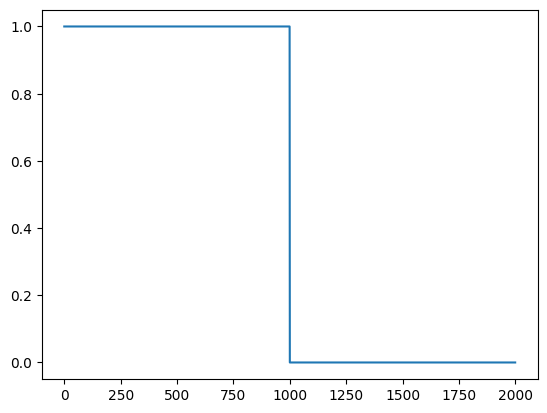

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


pkl_file = open('celeba_low_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
plt.plot(y)
y


3. 1D Power Spectrum

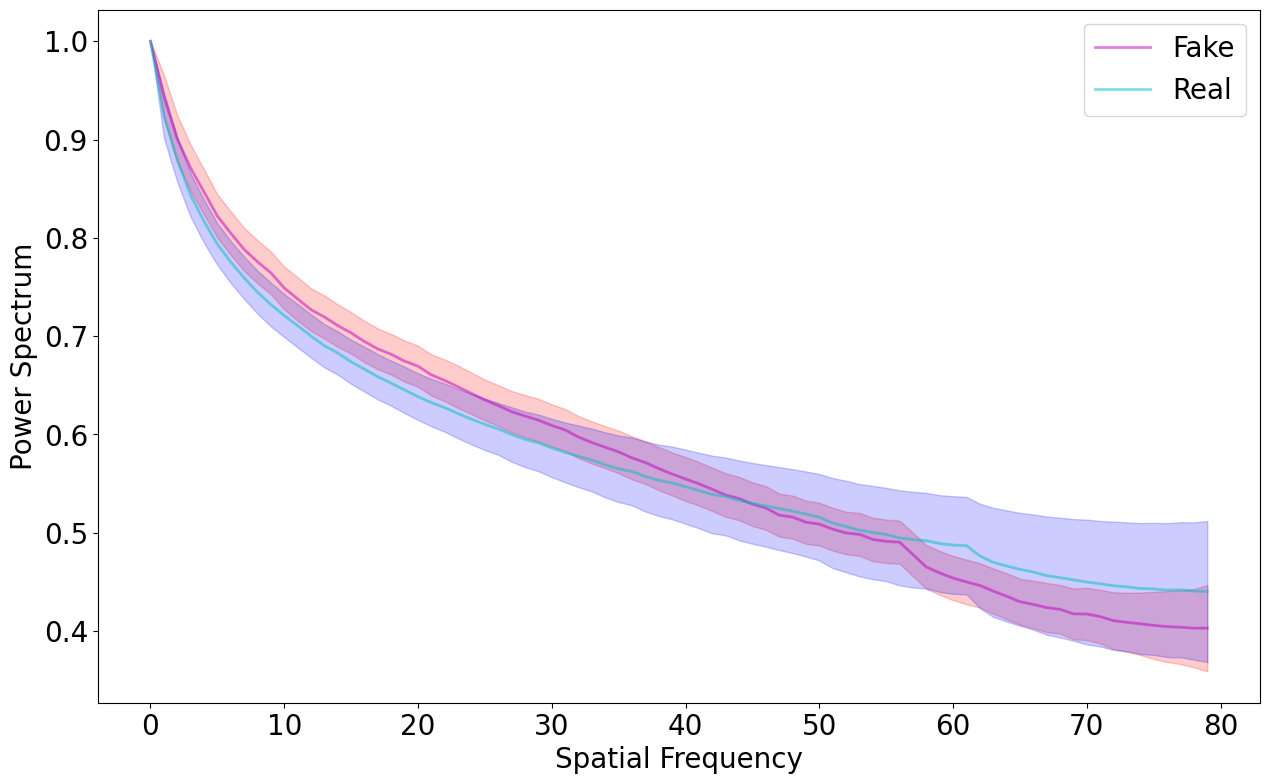

In [ ]:

num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='m', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='c', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
plt.savefig('1000_celeba.png', bbox_inches='tight')

3. Classifier Building

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 10
SVM = 0
SVM_r = 0
SVM_p = 0



for z in range(num):
    # read python dict back from the file
    pkl_file = open('celeba_low_1000.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    X = data["data"]
    y = data["label"]
    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        #Linear
        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        #Gaussian RBF
        from sklearn.svm import SVC
        svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
        svclassifier_r.fit(X_train, y_train)
        #Polynomial
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly')
        svclassifier_p.fit(X_train, y_train)
        SVM+=svclassifier.score(X_test, y_test)
        SVM_r+=svclassifier_r.score(X_test, y_test)
        SVM_p+=svclassifier_p.score(X_test, y_test)

    except:
        num-=1
        print(num)

print("Average SVM: "+str(SVM/num))
print("Average SVM_r: "+str(SVM_r/num))
print("Average SVM_p: "+str(SVM_p/num))


Average SVM: 0.9402500000000001
Average SVM_r: 0.9942500000000001
Average SVM_p: 0.9992500000000002


In [ ]:
from sklearn.metrics import mean_squared_error
import math
pred_l=svclassifier.predict(X_test)
mse= mean_squared_error(y_test, pred_l)
r=math.sqrt(mse)
r

0.1414213562373095

4. Linear Kernel Evaluation

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       191
         1.0       0.96      0.98      0.97       209

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



Text(50.722222222222214, 0.5, 'True labels')

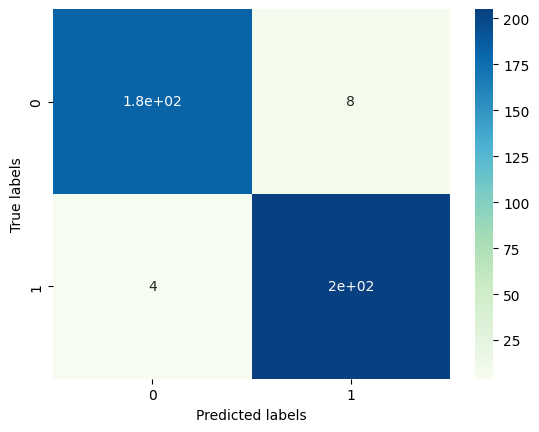

In [ ]:
########FOR LINEAR##############
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred_l=svclassifier.predict(X_test)
print(classification_report(y_test,pred_l))
cm_l=confusion_matrix(y_test,pred_l)
import seaborn as sns
sns.heatmap(cm_l,cmap="GnBu",annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

5.RBF Kernel Evaluation

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       191
         1.0       1.00      1.00      1.00       209

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



<Axes: >

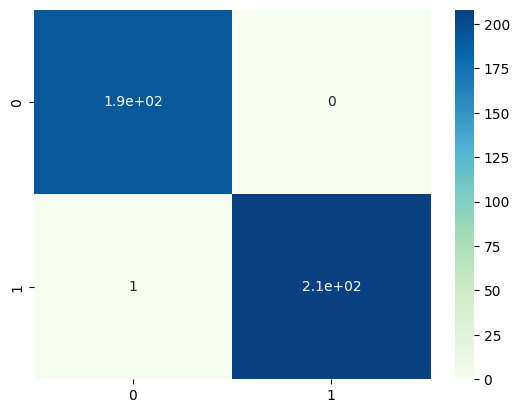

In [ ]:
########FOR GAUSSIAN RBF##############
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred_r=svclassifier_r.predict(X_test)
print(classification_report(y_test,pred_r))
cm_r=confusion_matrix(y_test,pred_r)
import seaborn as sns
sns.heatmap(cm_r,cmap="GnBu",annot=True)

6. Polynomial Kernel Evaluation

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       191
         1.0       1.00      1.00      1.00       209

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



<Axes: >

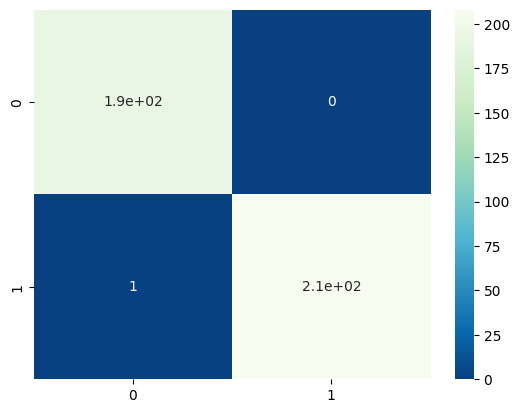

In [ ]:
########FOR POLYNOMIAL##############
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred_p=svclassifier_p.predict(X_test)
print(classification_report(y_test,pred_p))
cm_p=confusion_matrix(y_test,pred_p)
import seaborn as sns
sns.heatmap(cm_p,cmap="GnBu_r",annot=True)

7.SAVING MODEL AS A PICKLE FILE


In [ ]:
#SAVING MODEL AS A PICKLE FILE
with open("svclassifier_p.pkl","wb") as json_file:
    #json_file.write(svclassifier_p.to_pd())
    pickle.dump(svclassifier_p,json_file)
print("Saved model")

Saved model


 8. LOADING SAVED MODEL

In [ ]:
 loaded_model = pickle.load(open('svclassifier_p.pkl','rb'))